# Esercitazione 4

La struttura del jupyter notebook è la seguente:

- 4.0 caricamento dei pacchetti e introduzione;
- 4.1 sistemazione del codice di dinamica molecolare: (4.1.1) aggiungendo una flag che ci permetta di capire quando far ripartire il codice e (4.1.2) implementando la possibilità di riscalare le velocità, così da agevolare la convergenze dell'algoritmo allo stato di equilibrio ricercato;
- 4.2 implementare un metodo per misurare le grandezze di interesse e le loro incertezze (media a blocchi);
- 4.3 effettuare tre simulazioni e studiare la risposta dell'algoritmo nella stima delle grandezze di interesse nei casi solido, liquido e gas.

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.6, style='whitegrid') 

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [148]:
out_parte_1 = []
colors = ['blue', 'orange', 'purple', 'red']
names  = ['En. Potenziale', 'En. Cinetica', 'En. Totale', 'Temperatura']

out_parte_1.append(np.loadtxt("Code/4.1/output_epot.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_ekin.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_etot.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_temp.dat"))

## 12.1 - Sistemazione del codice

In questa prima parte dell'esercitazione abbiamo aggiunto al codice di dinamica molecolare contenuto in `MolDyn_NVE.cpp/h` alcuni metodi aggiuntivi:
- `Equilibrate_system(int N)` è un metodo pensato per simulare una fase di equilibrazione del sistema. Viene eseguito soltanto se la variabile `nstart` contenuta nel file `input.dat` assume valore `true`. In tal caso il programma inizializza il sistema eseguendo N passi dell'algoritmo di Verlet. Al termine di questo processo vengono salvate le ultime due configurazioni del sistema a `Npart=108` particelle e viene cambiato il valore di `nstart` da `true` a `false`. A questo punto vengono implementati `Nstep` passi dell'algoritmo di Verlet; come proposto nel codice fornito a lezione, vengono effettuate le misure delle grandezze ogni 10 passi, per questo motivo i valori rappresentati sull'asse delle ascisse nel grafico seguente devono essere moltiplicati per dieci per avere una corrispondenza con `Nstep`. 
- `rescale_velocities()` è un metodo nel quale ho implementato un riscalamento delle velocità ad un istante fissato della simulazione. L'idea è che, calcolando la temperatura $$ T(t+dt/2)=\frac{\sum_{i=1}^{N_{part}}|\vec{v}_i (t+dt/2)|^2}{3N_{part}}, \qquad \qquad \text{dove} \qquad \qquad \vec{v}(t+dt/2)=\frac{\vec{r}(t+dt)-\vec{r}(t)}{dt}, $$ sia possibile ricavare un fattore di riscalamento per la temperatura (e dunque anche per la velocità) nel modo seguente: $$ f_s = \biggl[\frac{T^*}{T(t+dt/2)}\biggr]^{1/2}, $$ dove ho indicato con $T^*$ la temperatura ideale che intendiamo raggiungere, fornita come input all'algoritmo tramite lettura del file `input.dat`;
- `Measure(bool)` è un metodo identico a quello proposto nel codice fornito a lezione, al quale ho aggiunto la possibilità di stabilire se l'utente desidera stampare sui files di output i valori delle misure, che vengono effettuate ogni 10 passi dell'algoritmo.

In questo primo esercizio ho utilizzato come input i valori contenuti nel file `input.solid`, al quale ho aggiunto la variabile `restart`, impostata con il valore `true` così da procedere con l'equilibrazione del sistema. Ho deciso di eseguire un'equilibrazione di 1000 passi, durante la quale ho effettuato un riscalamento delle velocità ogni 100 passi. In seguito, ho eseguito ulteriori 2000 passi dell'algoritmo, senza effettuare alcun riscalamento.

### Risultati ottenuti

Ho raccolto i risultati ottenuti nel grafico seguente.

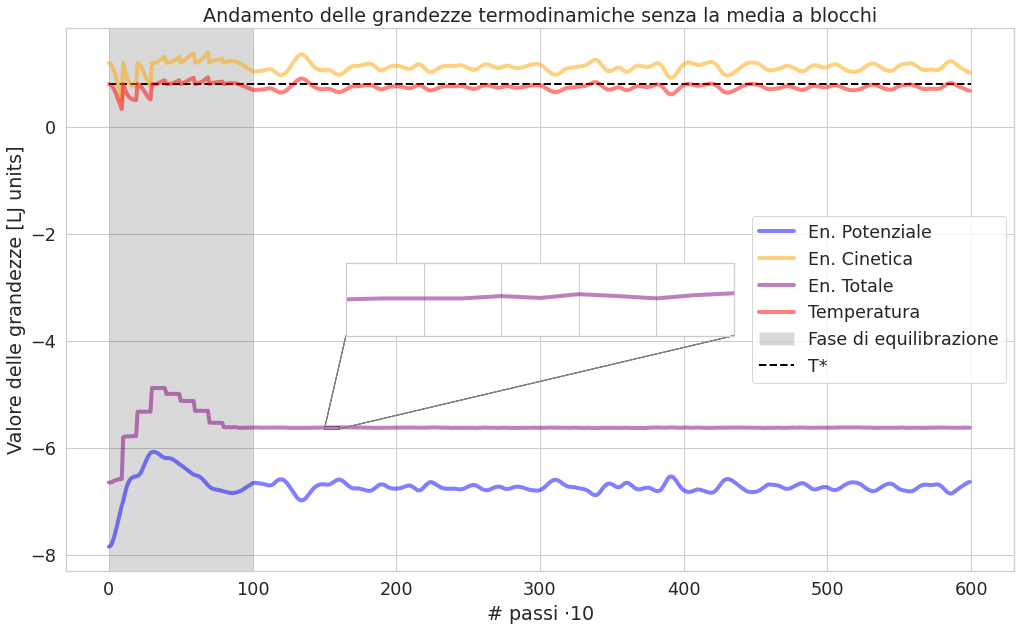

In [164]:

fig, ax = plt.subplots(figsize=[17, 10])
plt.title('Andamento delle grandezze termodinamiche senza la media a blocchi')
plt.xlabel('# passi $\cdot 10$')
plt.ylabel('Valore delle grandezze [LJ units]')

x1, x2, y1, y2 = 150, 160, -5.65, -5.6 
axins = zoomed_inset_axes(ax, zoom=27, loc=10)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

for i in range(4):
    ax.plot(out_parte_1[i], color=colors[i], alpha=0.5, linewidth=4, linestyle='-', label=names[i])
    axins.plot(out_parte_1[i], color=colors[i], alpha=0.5, linewidth=4, linestyle='-', label=names[i])
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
ax.hlines(0.8, 0, 600, color='black', linewidth=2, label='T*', linestyle='--')
ax.axvspan(0, 100, facecolor='black', alpha=0.15, label='Fase di equilibrazione')

ax.legend(loc=5)
plt.show()

__Figura 1:__ nel grafico sono rappresentati gli andamenti dei valori registrati per le quattro grandezze misurate ogni dieci passi dell'algoritmo. Si nota, in modo particolare osservando l'andamento dell'energia totale, il risultato dei riscalamenti delle velocità. Analizzando l'andamento della temperatura si vede inoltre come, dopo una prima fase di stabilizzazione, il valore oscilli attorno a quello desiderato, rappresentato in grafico con la linea nera tratteggiata.

## 12.2 - Misura delle grandezze con media a blocchi

In questa seconda parte dell'esercitazione abbiamo implementato un metodo per misurare effettivamente i valori delle grandezze di interesse (temperatura, energia cinetica, energia potenziale, energia totale). Nel farlo, abbiamo deciso di utilizzare il metodo `blocking`. Nello specifico, ho scritto il metodo `Blockin_on_MD(int M, int N, string filename)`, tramite cui ho eseguito una media a blocchi, i cui risultati cumulativi per ogni blocco sono salvati nel file `filename`. In questa esercitazione ho implementato autonomamente l'algoritmo della media a blocchi, che ho poi sostituito nell'esercitazione 7 con il metodo proposto a lezione. 

Ho eseguito questa nuova versione di codice partendo dallo stesso file di input utilizzato nell'esercizio 4.1; questa volta ho deciso di eseguire 5000 passi di equilibrazione, durante i quali ho riscalato dieci volte le velocità. A seguire, ho implementato $10^4$ passi dell'algoritmo di Verlet, sui quali ho eseguito la stima a blocchi (`Nblks=100`) dei valori delle quattro grandezze a cui siamo interessati.

In [175]:
ave_res = np.loadtxt("Code/4.2/ave_results.dat")

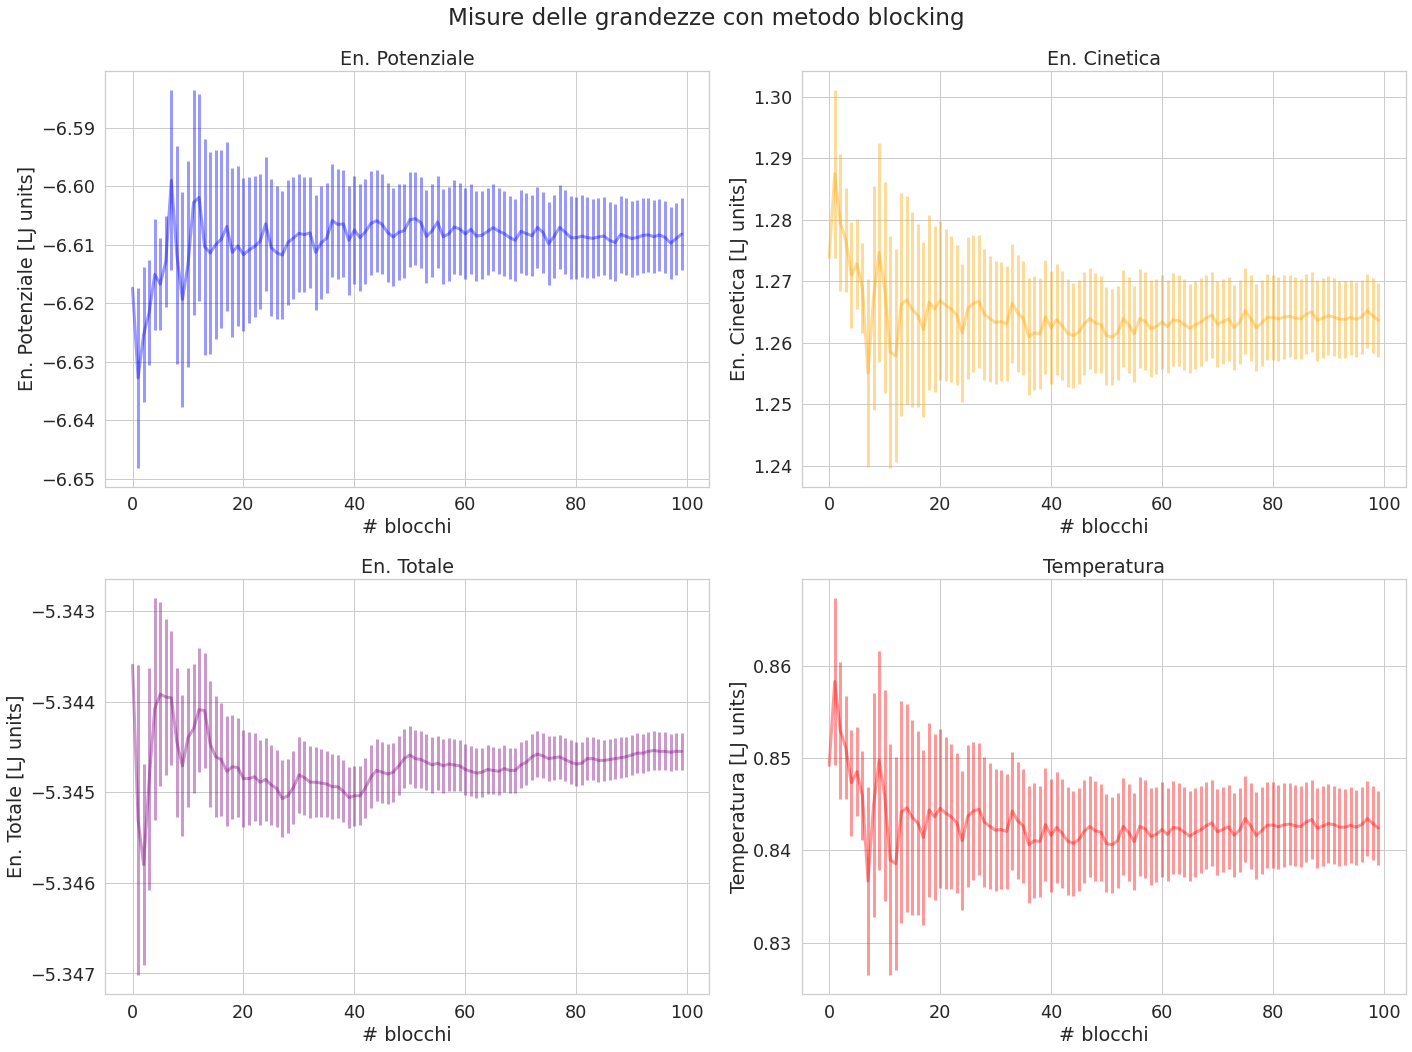

In [176]:
plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res.T[2*i], yerr=ave_res.T[2*i+1], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+' [LJ units]')
    
plt.tight_layout()

## 12.3 - Utilizzare il codice su tre casi diversi

Come terzo passaggio dell'esercitazione abbiamo infine utilizzato il codice per studiare l'evolversi verso l'equilibrio di tre stati diversi dell'Argon ($\sigma=0.34$nm, $\varepsilon/K_B = 120$K, $m=39.948$amu):
- fase solida: $\rho^*=1.1,\,\,T^*=0.8,\,\,r_c=2.2$
- fase liquida: $\rho^*=0.8,\,\,T^*=1.1,\,\,r_c=2.5$
- fase gassosa: $\rho^*=0.05,\,\,T^*=1.2,\,\,r_c=5.0$

### Fase solida

Per l'analisi della fase solida ho eseguito 2000 passi di equilibrazione, riscalando le velocità ogni 200 passi. A seguire $10^4$ passi di simulazione sui quali ho eseguito una media a blocchi con `Nblks=100`. 

In [191]:
temp_solid = np.loadtxt("Code/4.3/Risultati_belli/T_solid.dat")
ave_res_solid = np.loadtxt("Code/4.3/Risultati_belli/ave_solid.dat")

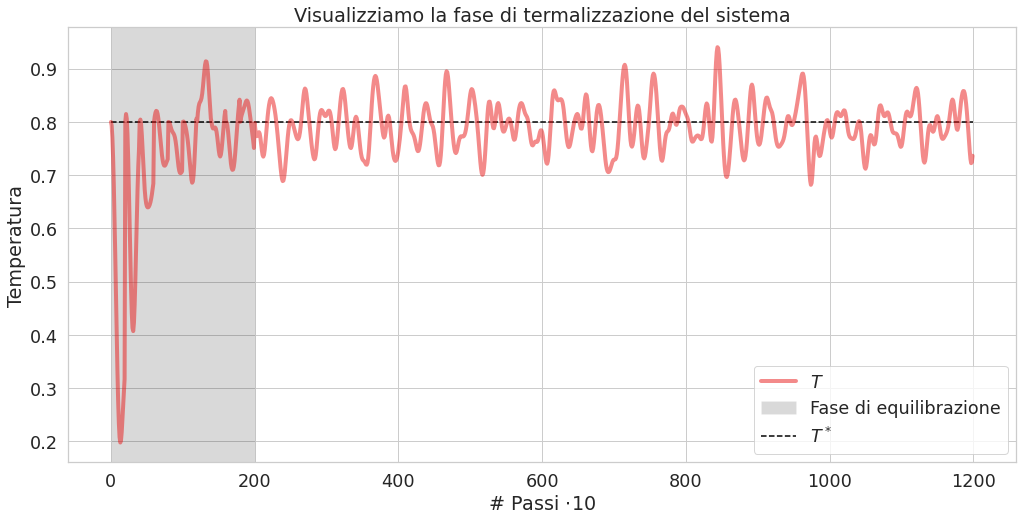

In [248]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp_solid, label='$T$', color='#e81717', linewidth=4, alpha=0.5)
plt.hlines(0.8, 0, 1200, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.axvspan(0, 200, facecolor='black', alpha=0.15, label='Fase di equilibrazione')
plt.legend(loc=4)
plt.xlabel("# Passi $\cdot 10$")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
plt.show()

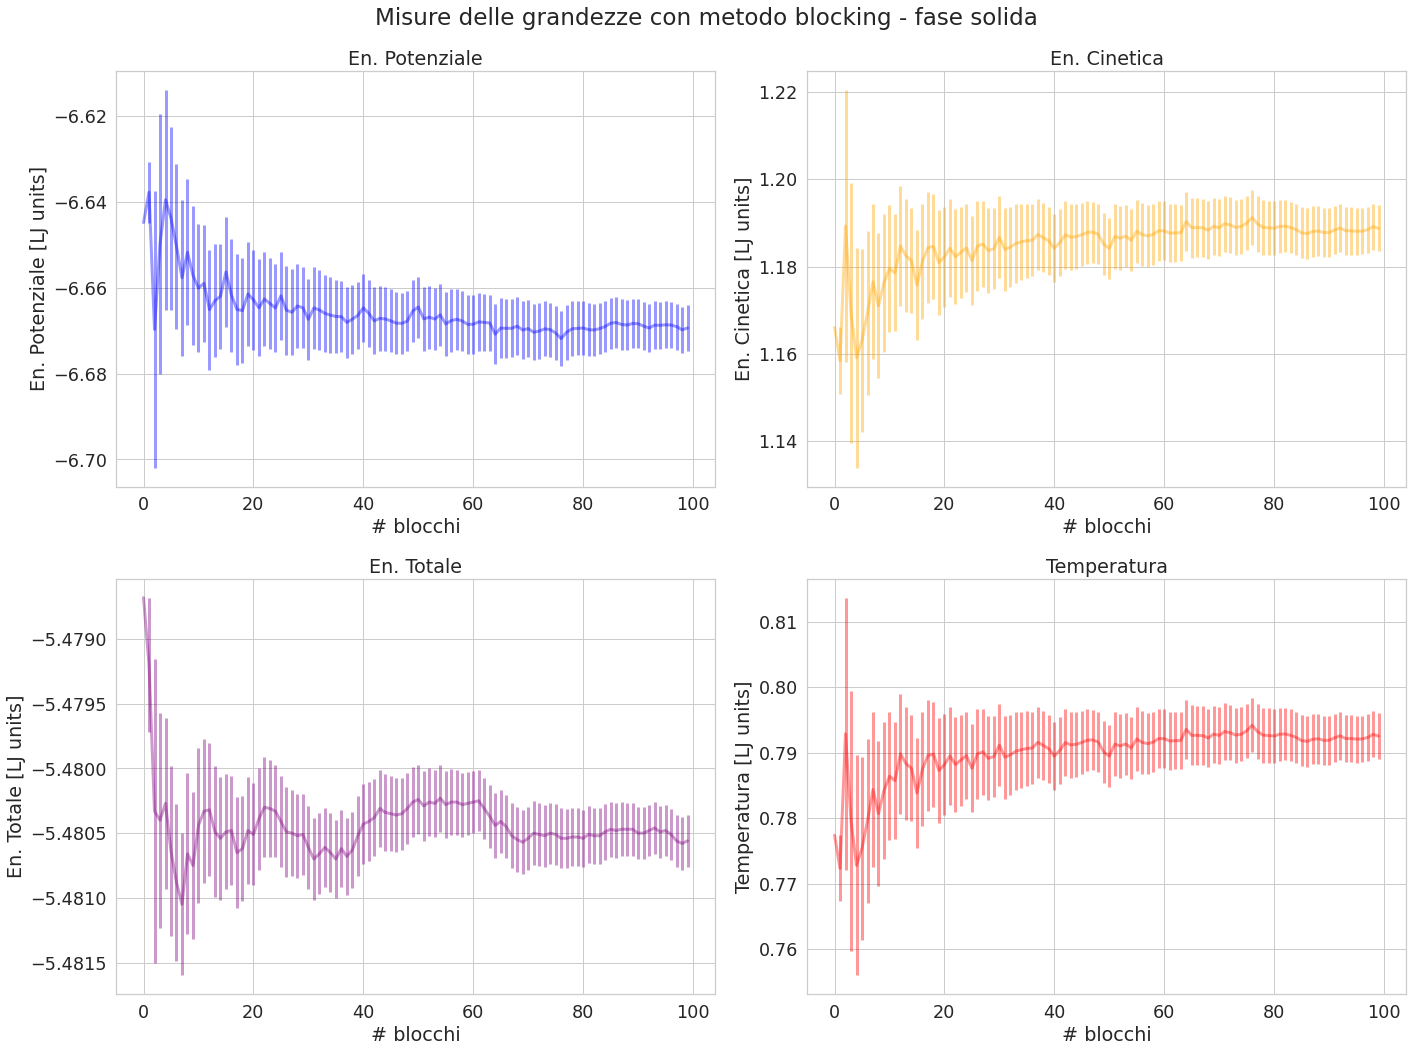

In [194]:
# fattori di conversione

K_B = 1.380649e-23
eps = 120*K_B
m   = 39.948*1.66054e-27
T_star = 120*0.8

fs = [eps, eps, eps, eps/K_B]

# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase solida')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_solid.T[2*i], yerr=ave_res_solid.T[2*i+1], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+' [LJ units]')
    
plt.tight_layout()

In [200]:
print('Valore finale di temperatura ottenuto: ', np.max(ave_res_solid.T[6]))
print('Errore relativo: ', (np.abs(np.max(ave_res_solid.T[6])-0.8))/0.8)

Valore finale di temperatura ottenuto:  0.794181
Errore relativo:  0.007273750000000023


__Figura 2:__ i risultati ottenuti presentano una temperatura $T=0.794$, dunque un errore relativo $\Delta T/T = (0.794-0.8)/0.8=0.007$, ossia dello 0.7%.

### Fase liquida

Per l'analisi della fase liquida ho eseguito 2000 passi di equilibrazione, riscalando le velocità ogni 200 passi. A seguire $10^4$ passi di simulazione sui quali ho eseguito una media a blocchi con `Nblks=100`. 

In [217]:
temp_liquid = np.loadtxt("Code/4.3/Risultati_belli/T_liquid.dat")
ave_res_liquid = np.loadtxt("Code/4.3/Risultati_belli/ave_liquid.dat")

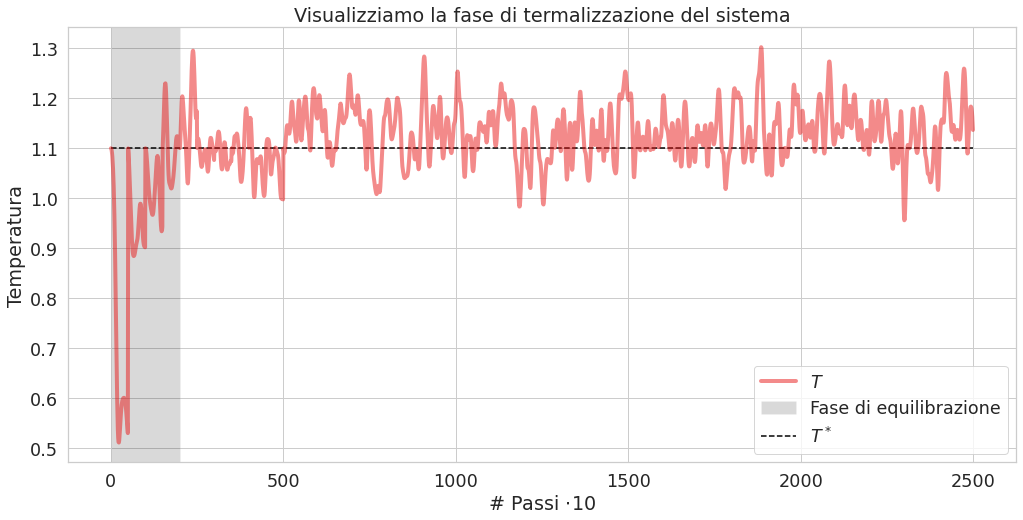

In [247]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp_liquid, label='$T$', color='#e81717', linewidth=4, alpha=0.5)
plt.hlines(1.1, 0, 2500, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.axvspan(0, 200, facecolor='black', alpha=0.15, label='Fase di equilibrazione')
plt.legend(loc=4)
plt.xlabel("# Passi $\cdot 10$")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
plt.show()

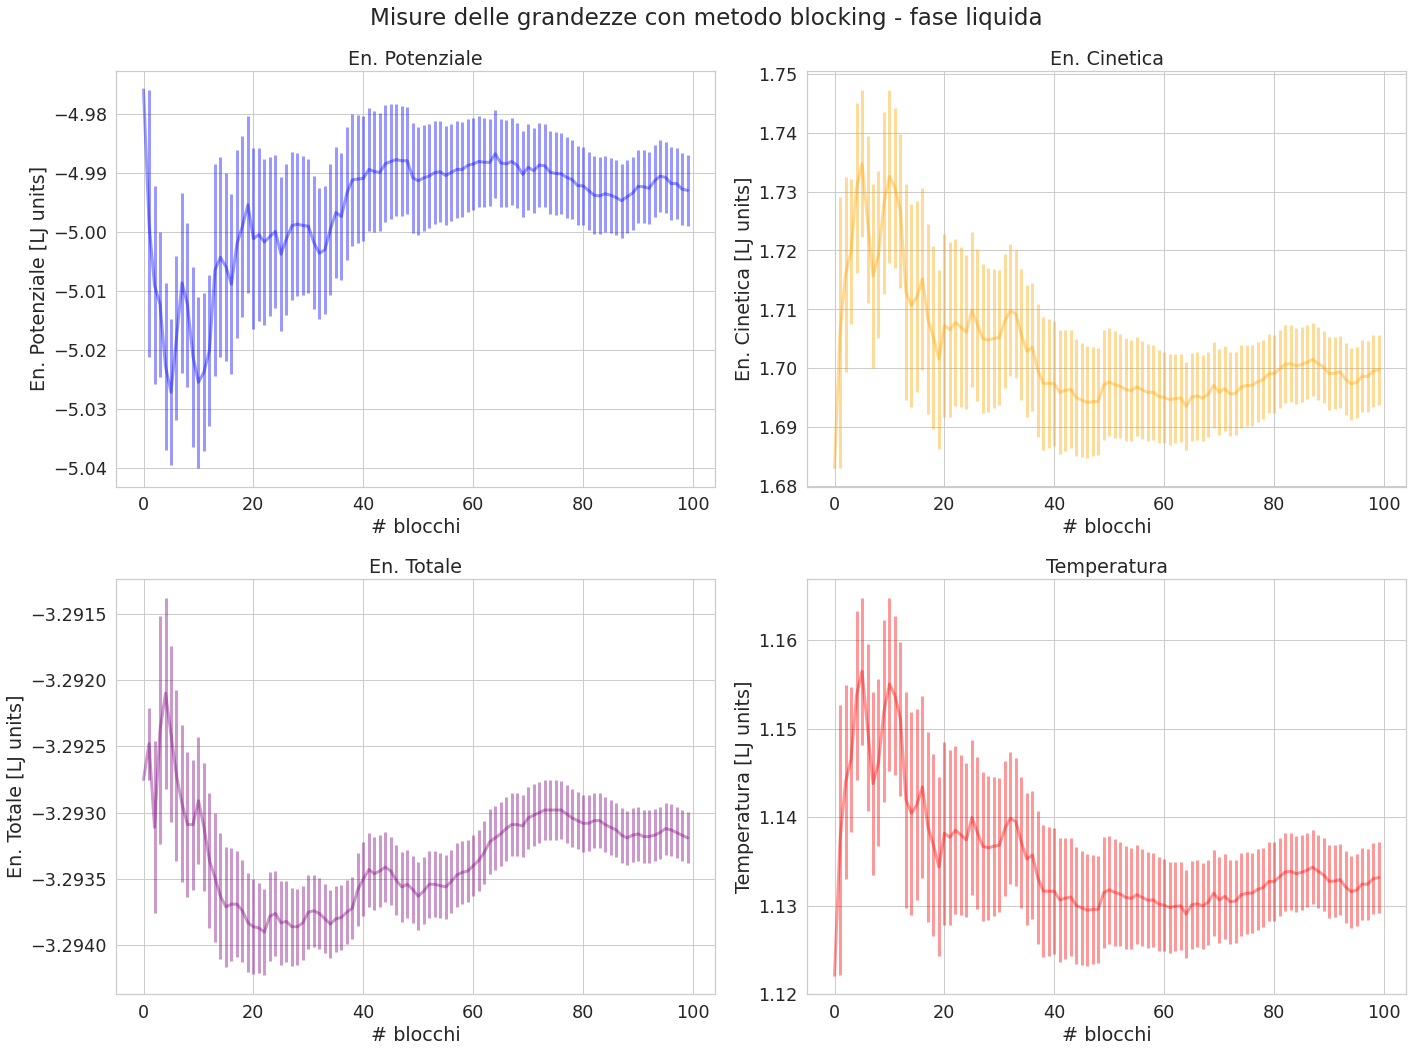

In [220]:
# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase liquida')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_liquid.T[2*i], yerr=ave_res_liquid.T[2*i+1], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+' [LJ units]')
    
plt.tight_layout()

## Gas

In [257]:
temp_gas = np.loadtxt("Code/4.3/Risultati_belli/T_gas.dat")
ave_res_gas = np.loadtxt("Code/4.3/Risultati_belli/ave_gas.dat")

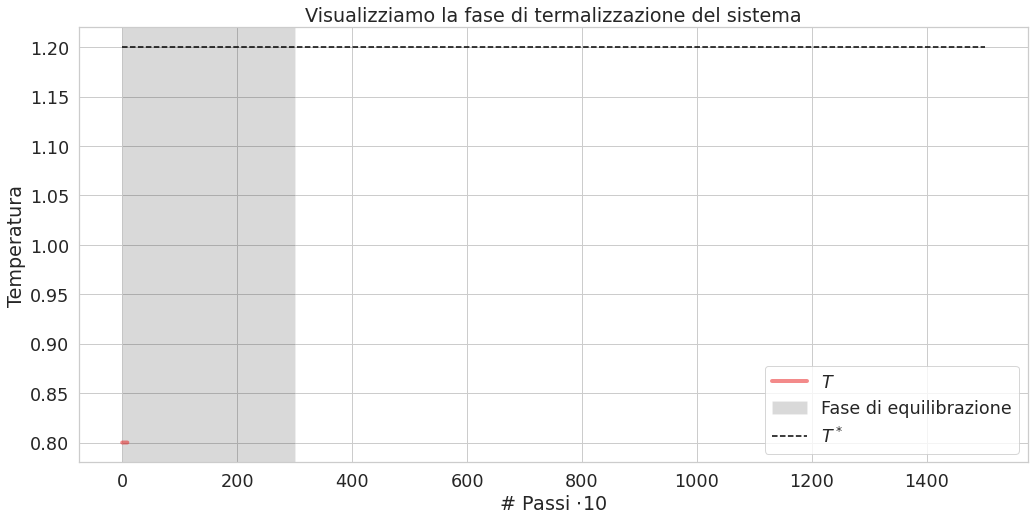

In [258]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp_gas, label='$T$', color='#e81717', linewidth=4, alpha=0.5)
plt.axvspan(0, 300, facecolor='black', alpha=0.15, label='Fase di equilibrazione')
plt.hlines(1.2, 0, 1500, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.legend(loc=4)
plt.xlabel("# Passi $\cdot 10$")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
plt.show()

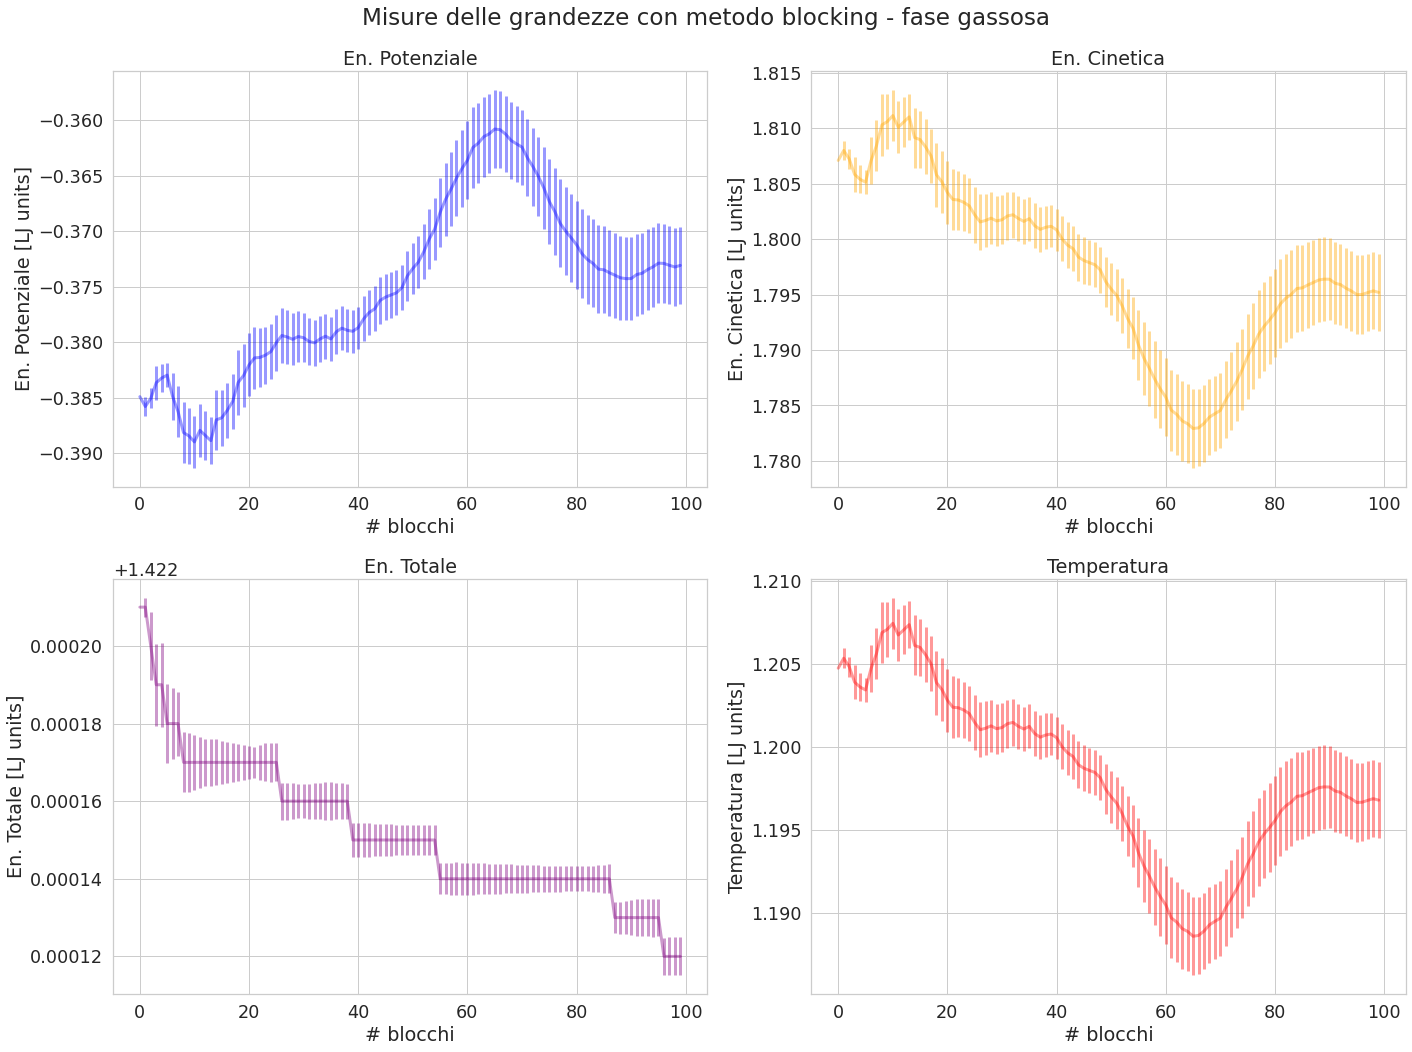

In [254]:
# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase gassosa')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_gas.T[2*i], yerr=ave_res_gas.T[2*i+1], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+' [LJ units]')
    
plt.tight_layout()